In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from image_fact import ImageFact

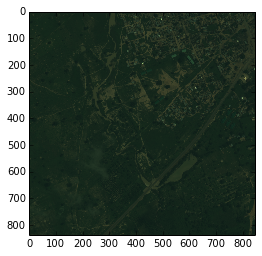

In [2]:
#i = ImageFact('6070_2_3', ['7', '8'])
i = ImageFact('6100_2_2', ['7', '8'])

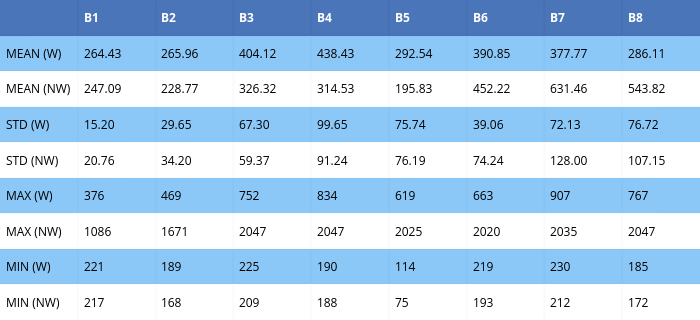

In [4]:
i.m_bands_stats()

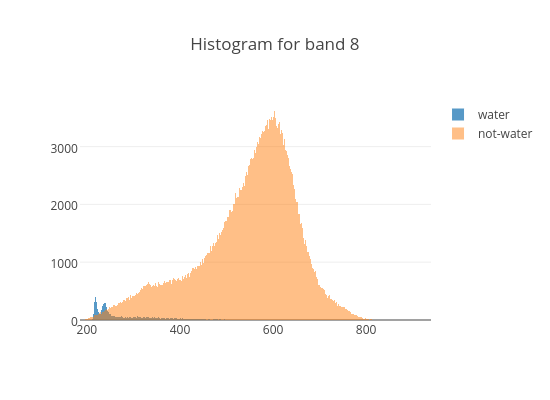

In [5]:
i.plot_histogram_of_band_in_img_m(8)

In [3]:
i.density_slicing(8, 116, 200)

(22, 693369, 150, 15398)

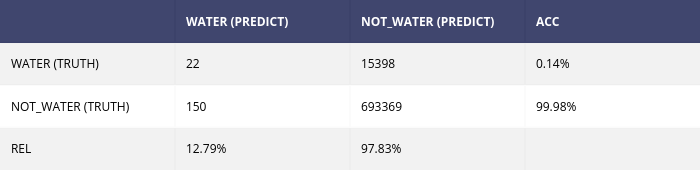

Average accuracy: 50.06%
Average reliability: 55.31%
Overall accuracy: 97.81%


In [4]:
i.analyze_result(22, 693369, 150, 15398)

In [242]:
# Split train and test groups

# reduced training samples size
tr_img_m_bands = np.dstack((i.img_m, i.combined_labels))
# ts_img_m_bands = np.dstack((i.img_m, i.combined_labels))

tr_water_dn = tr_img_m_bands[1 == tr_img_m_bands[:,:,8]]
tr_non_water_dn = tr_img_m_bands[0 == tr_img_m_bands[:,:,8]]

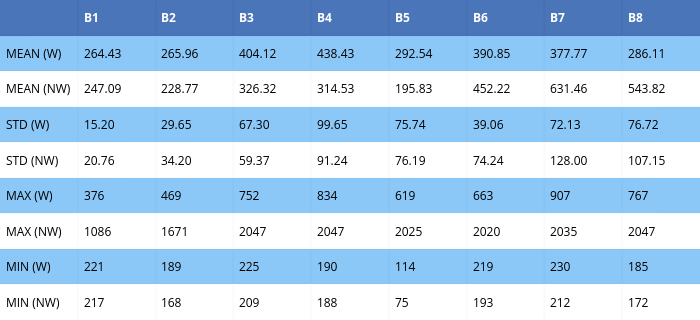

In [243]:
# Plot table on dn stats for the 8 band

def gen_dn_statics_for_table(dns):    
    dn_mean = np.mean(dns, axis = 0)
    dn_std = np.std(dns, axis = 0)
    dn_max = np.max(dns, axis = 0)
    dn_min = np.min(dns, axis = 0)    
    dn_mean_formatted = ['%1.2f'%dn for dn in dn_mean]
    dn_std_formatted = ['%1.2f'%dn for dn in dn_std]
    dn_max_formatted = ['%d'%dn for dn in dn_max]
    dn_min_formatted = ['%d'%dn for dn in dn_min]    
    return (dn_mean_formatted, dn_std_formatted, dn_max_formatted, dn_min_formatted, dn_mean, dn_std, dn_max, dn_min)
    
water_dn_mean_formatted, water_dn_std_formatted, water_dn_max_formatted, water_dn_min_formatted, _, _, _, _ = gen_dn_statics_for_table(tr_water_dn[:,0:8])
water_dn_mean_formatted.insert(0, 'MEAN (W)')
water_dn_std_formatted.insert(0, 'STD (W)')
water_dn_max_formatted.insert(0, 'MAX (W)')
water_dn_min_formatted.insert(0, 'MIN (W)')

non_water_dn_mean_formatted, non_water_dn_std_formatted, non_water_dn_max_formatted, non_water_dn_min_formatted, _, _, _, _ = gen_dn_statics_for_table(tr_non_water_dn[:,0:8])
non_water_dn_mean_formatted.insert(0, 'MEAN (NW)')
non_water_dn_std_formatted.insert(0, 'STD (NW)')
non_water_dn_max_formatted.insert(0, 'MAX (NW)')
non_water_dn_min_formatted.insert(0, 'MIN (NW)')

colorscale = [[0, '#0D47A1'],[.5, '#64B5F6'],[1, '#ffffff']]
table = ff.create_table([
    ['', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'],
    water_dn_mean_formatted,
    non_water_dn_mean_formatted,    
    water_dn_std_formatted,
    non_water_dn_std_formatted,    
    water_dn_max_formatted,
    non_water_dn_max_formatted,    
    water_dn_min_formatted,        
    non_water_dn_min_formatted
], colorscale=colorscale)

py.image.ishow(table)

In [247]:
# plot dn histogram for band

def plot_histogram_for_band(b,i = False):
    start = np.min(tr_water_dn[:,b-1])
    end = np.mean(tr_img_m_bands[:,:,b-1]) * 1.75
    data = [
        go.Histogram(
            x=tr_water_dn[:,b-1],
            opacity=0.75,
            name='water',
            autobinx=False,
            xbins=dict(
                start=start,
                end=end,
                size=1
            )
        ),
        go.Histogram(
            x=tr_non_water_dn[:,b-1],
            opacity=0.5,
            name='not-water',
            autobinx=False,
            xbins=dict(
                start=start,
                end=end,
                size=1
            )
        )
    ]
    layout = go.Layout(barmode='overlay', bargap=0, bargroupgap=0, title='Histogram for band ' + str(b))
    fig = go.Figure(data=data, layout=layout)

    if i:
        py.iplot(fig, filename=str(b))
    else:
        py.image.ishow(fig, width = 550, height = 400)

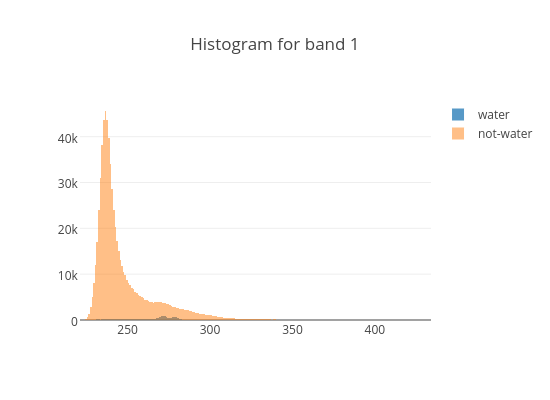

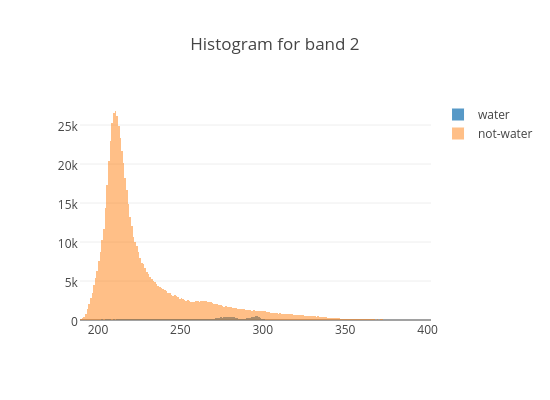

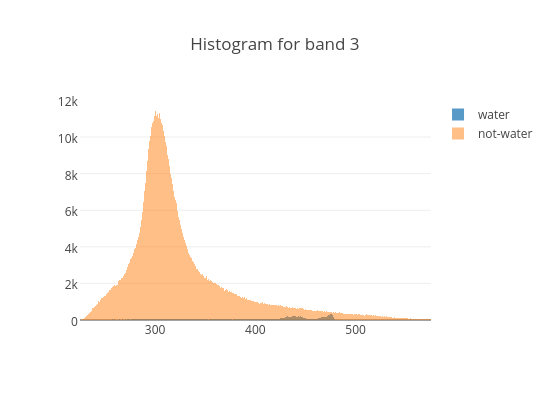

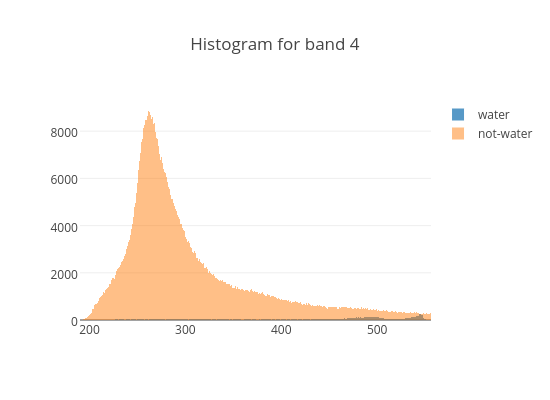

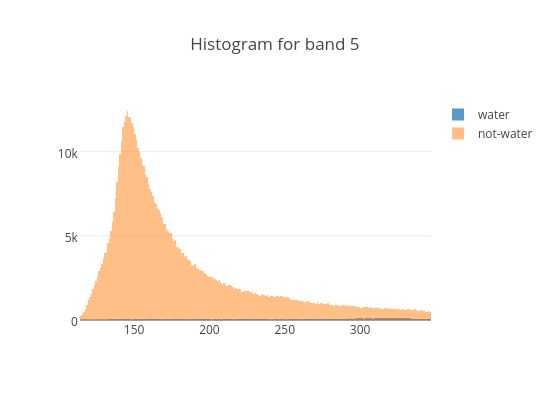

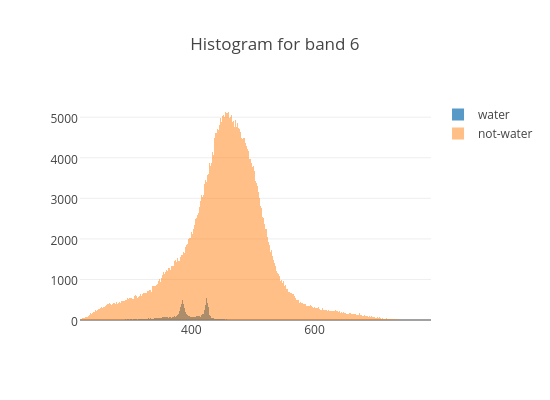

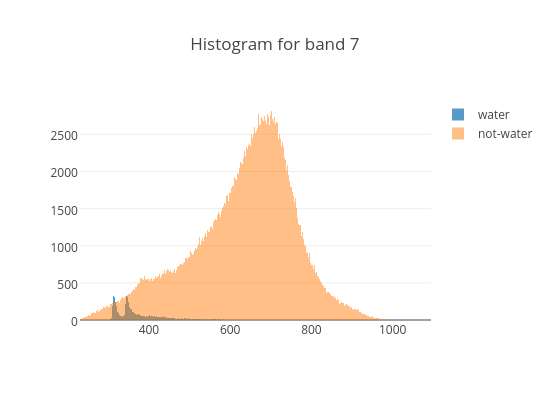

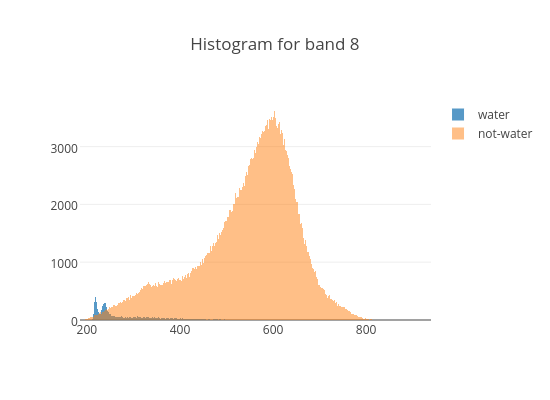

In [248]:
plot_histogram_for_band(1)
plot_histogram_for_band(2)
plot_histogram_for_band(3)
plot_histogram_for_band(4)
plot_histogram_for_band(5)
plot_histogram_for_band(6)
plot_histogram_for_band(7)
plot_histogram_for_band(8)

In [167]:
# band 6, 8 for density slicing
def density_slicing(data, band, lower_limit, upper_limit):
    tp = tn = fp = fn = 0
    band_data = data[:, :, [band-1, 8]].reshape(-1, 2)
    for d in band_data:
        dn = d[0]
        lb = d[1]
        if lower_limit >= dn or upper_limit <= dn:
            if lb == 0:
                tn += 1
            else:
                fn += 1
        else:
            if lb == 1:
                tp += 1
            else:
                fp += 1
            
    return tp, tn, fp, fn

In [107]:
def analyze_result(tp, tn, fp, fn):
    table = ff.create_table([
        ['', 'WATER (PREDICT)', 'NOT_WATER (PREDICT)', 'ACC'],
        ['WATER (TRUTH)', tp, fn, '%.2f%%'%(100 * tp / (tp + fn))],
        ['NOT_WATER (TRUTH)', fp, tn, '%.2f%%'%(100 * tn / (fp + tn))],
        ['REL', '%.2f%%'%(100 * tp / (tp + fp)), '%.2f%%'%(100 * tn / (fn + tn))]
    ], index_title='asdasd')
    py.image.ishow(table)
    print('Average accuracy: ' + '%.2f%%'%(100 * (tp / (tp + fn) + tn / (fp + tn)) / 2))
    print('Average reliability: ' + '%.2f%%'%(100 * (tp / (tp + fp) + tn / (fn + tn)) / 2))
    print('Overall accuracy: ' + '%.2f%%'%(100 * (tp + tn) / (tp + tn + fp + fn)))

RESULT ON BAND 7:


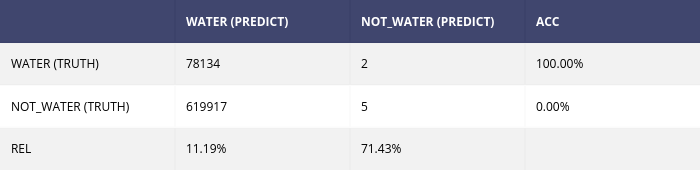

Average accuracy: 50.00%
Average reliability: 41.31%
Overall accuracy: 11.19%


In [171]:
print('RESULT ON BAND 7:')
b7_tp, b7_tn, b7_fp, b7_fn = density_slicing(tr_img_m_bands, 7, 166, 1138)
analyze_result(b7_tp, b7_tn, b7_fp, b7_fn)

RESULT ON BAND 7:


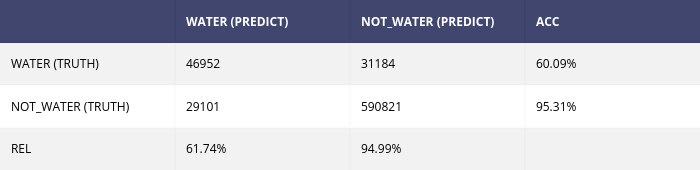

Average accuracy: 77.70%
Average reliability: 78.36%
Overall accuracy: 91.36%


In [148]:
print('RESULT ON BAND 7:')
b7_tp, b7_tn, b7_fp, b7_fn = density_slicing(tr_img_m_bands, 7, 164, 257)
analyze_result(b7_tp, b7_tn, b7_fp, b7_fn)

RESULT ON BAND 8:


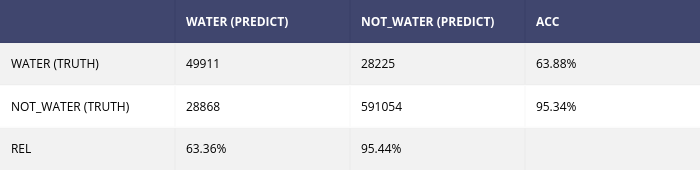

Average accuracy: 79.61%
Average reliability: 79.40%
Overall accuracy: 91.82%


In [123]:
print('RESULT ON BAND 8:')
b8_tp, b8_tn, b8_fp, b8_fn = density_slicing(tr_img_m_bands, 8, 116, 200)
analyze_result(b8_tp, b8_tn, b8_fp, b8_fn)

RESULT ON TEST DATA BAND 7:


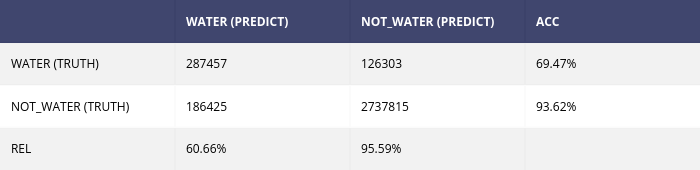

Average accuracy: 81.55%
Average reliability: 78.13%
Overall accuracy: 90.63%


In [119]:
#See how it performs on unseen data

print('RESULT ON TEST DATA BAND 7:')
ts_b7_tp, ts_b7_tn, ts_b7_fp, ts_b7_fn = density_slicing(ts_img_m_bands, 7, 164, 265)
analyze_result(ts_b7_tp, ts_b7_tn, ts_b7_fp, ts_b7_fn)

RESULT ON TEST DATA BAND 8:


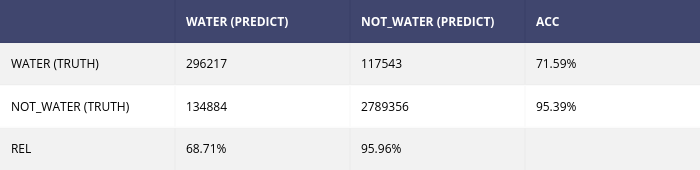

Average accuracy: 83.49%
Average reliability: 82.33%
Overall accuracy: 92.44%


In [120]:
print('RESULT ON TEST DATA BAND 8:')
ts_b8_tp, ts_b8_tn, ts_b8_fp, ts_b8_fn = density_slicing(ts_img_m_bands, 8, 116, 200)
analyze_result(ts_b8_tp, ts_b8_tn, ts_b8_fp, ts_b8_fn)

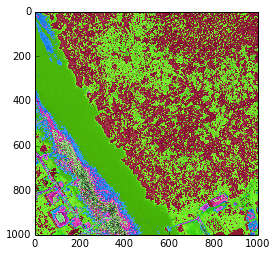

In [16]:
plt.imshow(i.img_rgb[2000:3000, 1500:2500, :])

<matplotlib.colorbar.Colorbar instance at 0x7f542b7e3758>

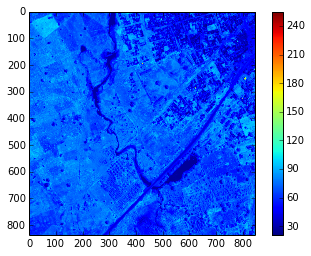

In [257]:
plt.imshow(cv2.convertScaleAbs(i.img_m[:, :, 7], alpha=(255.0/2048.0)))
plt.colorbar()